In [14]:
%matplotlib inline
import os
import re
import torch
from torch import nn
import d2l_torch as d2l
from torch.nn import functional as F

In [7]:
d2l.DATA_HUB['SNLI'] = (
    'https://nlp.stanford.edu/projects/snli/snli_1.0.zip',
    '9fcde07509c7e87ec61c640c1b2753d9041758e4')

data_dir = "..\data\snli_1.0"

In [8]:
def read_snli(data_dir, is_train):
    """将SNLI数据集解析为前提、假设和标签"""

    def extract_text(s):
        # 删除我们不会使用的信息
        s = re.sub('\\(', '', s)
        s = re.sub('\\)', '', s)
        # 用一个空格替换两个或多个连续的空格
        s = re.sub('\\s{2,}', ' ', s)
        return s.strip()

    label_set = {'entailment': 0, 'contradiction': 1, 'neutral': 2}
    file_name = os.path.join(data_dir, 'snli_1.0_train.txt'
    if is_train else 'snli_1.0_test.txt')
    with open(file_name, 'r') as f:
        rows = [row.split('\t') for row in f.readlines()[1:]]
    premises = [extract_text(row[1]) for row in rows if row[0] in label_set]
    hypotheses = [extract_text(row[2]) for row in rows if row[0] \
                  in label_set]
    labels = [label_set[row[0]] for row in rows if row[0] in label_set]
    return premises, hypotheses, labels

In [9]:
class SNLIDataset(torch.utils.data.Dataset):
    """用于加载SNLI数据集的自定义数据集"""

    def __init__(self, dataset, num_steps, vocab=None):
        self.num_steps = num_steps
        all_premise_tokens = d2l.tokenize(dataset[0])
        all_hypothesis_tokens = d2l.tokenize(dataset[1])
        if vocab is None:
            self.vocab = d2l.Vocab(all_premise_tokens + \
                                   all_hypothesis_tokens, min_freq=5, reserved_tokens=['<pad>'])
        else:
            self.vocab = vocab
        self.premises = self._pad(all_premise_tokens)
        self.hypotheses = self._pad(all_hypothesis_tokens)
        self.labels = torch.tensor(dataset[2])
        print('read ' + str(len(self.premises)) + ' examples')

    def _pad(self, lines):
        return torch.tensor([d2l.truncate_pad(
            self.vocab[line], self.num_steps, self.vocab['<pad>'])
            for line in lines])

    def __getitem__(self, idx):
        return (self.premises[idx], self.hypotheses[idx]), self.labels[idx]

    def __len__(self):
        return len(self.premises)

In [10]:
def load_data_snli(batch_size, num_steps=50):
    """下载SNLI数据集并返回数据迭代器和词表"""
    num_workers = d2l.get_dataloader_workers()
    # data_dir = d2l.download_extract('SNLI')
    train_data = read_snli(data_dir, True)
    test_data = read_snli(data_dir, False)
    train_set = SNLIDataset(train_data, num_steps)
    test_set = SNLIDataset(test_data, num_steps, train_set.vocab)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                             shuffle=True,
                                             num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                            shuffle=False,
                                            num_workers=num_workers)
    return train_iter, test_iter, train_set.vocab

In [11]:
train_iter, test_iter, vocab = load_data_snli(128, 50)
print(len(vocab))

read 549367 examples
read 9824 examples
18678


In [12]:
for X, Y in train_iter:
    print(X[0].shape)
    print(X[1].shape)
    print(Y.shape)
    break

torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128])


### 鉴于许多模型都是基于复杂而深度的架构，Parikh等人提出用注意力机制解决自然语言推断问题，并称之为“可分解注意力模型”

　<font color='red'> 这使得模型没有循环层或卷积层，在SNLI数据集上以更少的参数实现了当时的最佳结果。本节将描述并实现这种基于注意力的自然语言推断方法（使用MLP） </font>

![将预训练GloVe送入基于注意力和MLP的自然语言推断架构](draw/nli1.png)

　<font color='red'>与保留前提和假设中词元的顺序相比，我们可以将一个文本序列中的词元与另一个文本序列中的每个词元对齐，然后比较和聚合这些信息，以预测前提和假设之间的逻辑关系。与机器翻译中源句和目标句之间的词元对齐类似，前提和假设之间的词元对齐可以通过注意力机制灵活地完成。 </font>

![利用注意力机制进行自然语言推断](draw/nli2.png)

### 从高层次上讲，它由三个联合训练的步骤组成：对齐、比较和汇总

In [15]:
# 在下面的mlp函数中定义的多层感知机
def mlp(num_inputs, num_hiddens, flatten):
    net = []
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_inputs, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_hiddens, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    return nn.Sequential(*net)

In [16]:
# 定义Attend类来计算假设（beta）与输入前提A的软对齐以及前提（alpha）与输入假设B的软对齐
class Attend(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Attend, self).__init__(**kwargs)
        self.f = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B):
        # A/B的形状：（批量大小，序列A/B的词元数，embed_size）
        # f_A/f_B的形状：（批量大小，序列A/B的词元数，num_hiddens）
        f_A = self.f(A)
        f_B = self.f(B)
        # e的形状：（批量大小，序列A的词元数，序列B的词元数）
        e = torch.bmm(f_A, f_B.permute(0, 2, 1))
        # beta的形状：（批量大小，序列A的词元数，embed_size），
        # 意味着序列B被软对齐到序列A的每个词元(beta的第1个维度)
        beta = torch.bmm(F.softmax(e, dim=-1), B)
        # beta的形状：（批量大小，序列B的词元数，embed_size），
        # 意味着序列A被软对齐到序列B的每个词元(alpha的第1个维度)
        alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)
        return beta, alpha

In [17]:
# 比较
# 软对齐中，一个序列中的所有词元（尽管可能具有不同的注意力权重）将与另一个序列中的词元进行比较
# 述的注意（attending）步骤确定前提中的“need”和“sleep”都与假设中的“tired”对齐，则将对“疲倦-需要睡眠”进行比较
class Compare(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Compare, self).__init__(**kwargs)
        self.g = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B, beta, alpha):
        V_A = self.g(torch.cat([A, beta], dim=2))
        V_B = self.g(torch.cat([B, alpha], dim=2))
        return V_A, V_B

In [19]:
# 聚合
# 接下来，我们将两个求和结果的连结提供给函数（一个多层感知机），以获得逻辑关系的分类结果
class Aggregate(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
        super(Aggregate, self).__init__(**kwargs)
        self.h = mlp(num_inputs, num_hiddens, flatten=True)
        self.linear = nn.Linear(num_hiddens, num_outputs)

    def forward(self, V_A, V_B):
        # 对两组比较向量分别求和
        V_A = V_A.sum(dim=1)
        V_B = V_B.sum(dim=1)
        # 将两个求和结果的连结送到多层感知机中
        Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))
        return Y_hat

In [20]:
# 通过将注意步骤、比较步骤和聚合步骤组合在一起，我们定义了可分解注意力模型来联合训练这三个步骤
class DecomposableAttention(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100,
                 num_inputs_compare=200, num_inputs_agg=400, **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(len(vocab), embed_size)
        self.attend = Attend(num_inputs_attend, num_hiddens)
        self.compare = Compare(num_inputs_compare, num_hiddens)
        # 有3种可能的输出：蕴涵、矛盾和中性
        self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)

    def forward(self, X):
        premises, hypotheses = X
        A = self.embedding(premises)
        B = self.embedding(hypotheses)
        beta, alpha = self.attend(A, B)
        V_A, V_B = self.compare(A, B, beta, alpha)
        Y_hat = self.aggregate(V_A, V_B)
        return Y_hat

### 创建与训练模型

In [45]:
def train_transformer(lr=0.001, num_epochs=5):
    embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
    net = DecomposableAttention(vocab, embed_size, num_hiddens)
    glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
    embeds = glove_embedding[vocab.idx_to_token]
    net.embedding.weight.data.copy_(embeds);
    # lr, num_epochs = 0.001, 4
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss(reduction="none")
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
        devices)
    torch.save(net.state_dict(), 'model/nli_transformer_jupyter.pth')

loss 0.438, train acc 0.831, test acc 0.825
14150.8 examples/sec on [device(type='cuda', index=0)]


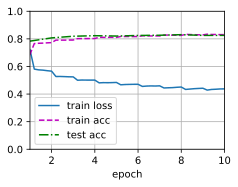

In [46]:
train_transformer(num_epochs=10)

### 推理

In [49]:
def infer_snli_transformer(vocab, premise, hypothesis):
    """预测前提和假设之间的逻辑关系"""
    print('premise:', premise)
    print('hypothesis:', hypothesis)
    embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
    model = DecomposableAttention(vocab, embed_size, num_hiddens)
    model.load_state_dict(torch.load('model/nli_transformer_jupyter.pth'))
    model = model.to(d2l.try_gpu())
    model.eval()  # 设置模型为推理模式
    premise = torch.tensor(vocab[premise.split()], device=d2l.try_gpu())
    hypothesis = torch.tensor(vocab[hypothesis.split()], device=d2l.try_gpu())
    label = torch.argmax(model([premise.reshape((1, -1)),
                           hypothesis.reshape((1, -1))]), dim=1)
    return 'entailment' if label == 0 else 'contradiction' if label == 1 \
            else 'neutral'

In [26]:
print('i am joker'.split())

['i', 'am', 'joker']


In [50]:
describe = [
['i am good', 'i am bad'],
    ['Two women are hugging each other.', 'Two women are showing affection.'],
    ['两个女人拥抱在一起', '两个女人在示爱'],
    [ 'i am tired', 'i want to sheep'],
    ['i am hungery', 'i starve'],
    ['i am hungery', 'i want to eat meal'],
    ['i am hungery', 'i want to eat meat'],
    ['i want to eat meat', 'i want to eat meal'],
    ['i like gone with the wind', 'i like the charactor scarlet'],
    ['i like gone with the wind', 'i hate reading'],
    ['i like gone with the wind', 'i also like the shortest history of europe']
]
for desc in describe:
    print(infer_snli_transformer(vocab, desc[0], desc[1]))
    print('---------------------------------')

premise: i am good
hypothesis: i am bad
contradiction
---------------------------------
premise: Two women are hugging each other.
hypothesis: Two women are showing affection.
neutral
---------------------------------
premise: 两个女人拥抱在一起
hypothesis: 两个女人在示爱
entailment
---------------------------------
premise: i am tired
hypothesis: i want to sheep
neutral
---------------------------------
premise: i am hungery
hypothesis: i starve
contradiction
---------------------------------
premise: i am hungery
hypothesis: i want to eat meal
contradiction
---------------------------------
premise: i am hungery
hypothesis: i want to eat meat
contradiction
---------------------------------
premise: i want to eat meat
hypothesis: i want to eat meal
entailment
---------------------------------
premise: i like gone with the wind
hypothesis: i like the charactor scarlet
neutral
---------------------------------
premise: i like gone with the wind
hypothesis: i hate reading
contradiction
-----------------